In [1]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim.lr_scheduler import StepLR 
from torchinfo import summary
from tqdm.notebook import tqdm

import mlflow
import mlflow.pytorch

In [2]:
# force project root into sys.path
project_root = os.path.abspath("..")
print("Using project root:", project_root)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

Using project root: c:\Users\DELL\Desktop\endtoend-mlops\projects\covid_chest_classifier


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print(f"Using {device} device")

Using cpu device


In [4]:
data_dir = "C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Will read traindata from", train_dir)
print("And the test data from", test_dir)

Will read traindata from C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//train
And the test data from C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//test


In [5]:
classes = os.listdir(train_dir)

print("List of classes:", classes)

List of classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [7]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches +=1
    mean = channels_sum/num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    
    return mean, std

In [8]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225)
            )
   ]
    )

print(type(transform_normalized))
print("-------------")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
-------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [9]:
normalized_dataset = datasets.ImageFolder(root=train_dir, transform=transform_normalized)

print('Length of dataset:', len(normalized_dataset))

Length of dataset: 251


In [10]:
g = torch.Generator()
g.manual_seed(42)

In [11]:
train_dataset, val_dataset = random_split(normalized_dataset, [0.8, 0.2], generator=g)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_normalized)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))
print("Length of test dataset:", len(test_dataset))

Length of training dataset: 201
Length of validation dataset: 50
Length of test dataset: 66


In [12]:
percent_train = np.round(100*len(train_dataset)/ len(normalized_dataset),2)
percent_val = np.round(100*len(val_dataset) / len(normalized_dataset), 2)


print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val} of full data")

Train data is 80.08% of full data
Validation data is 19.92 of full data


In [13]:
def class_counts(dataset):
    ds = dataset.dataset if isinstance(dataset, Subset) else dataset
    counts = Counter(lbl for _, lbl in tqdm(dataset, desc="Counting classes"))
    return pd.Series({cls: counts[idx] for cls, idx in ds.class_to_idx.items()})

In [14]:
train_class_distributions = class_counts(train_dataset)
train_class_distributions

Counting classes:   0%|          | 0/201 [00:00<?, ?it/s]

Covid              94
Normal             56
Viral Pneumonia    51
dtype: int64

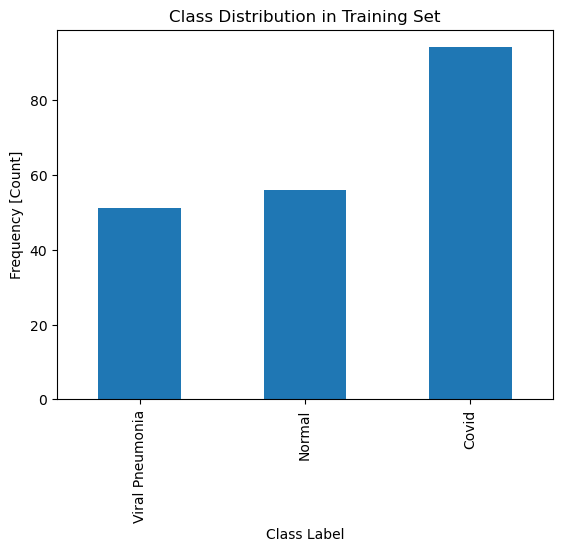

In [15]:
train_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Training Set");

Counting classes:   0%|          | 0/50 [00:00<?, ?it/s]

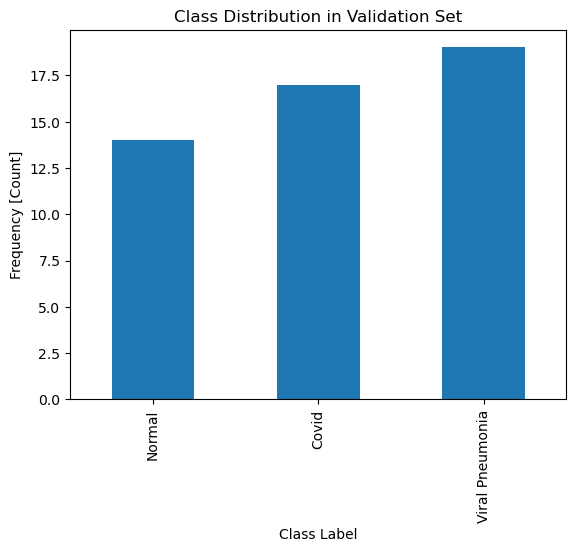

In [16]:
validation_class_distributions = class_counts(val_dataset)

validation_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Validation Set");

Counting classes:   0%|          | 0/66 [00:00<?, ?it/s]

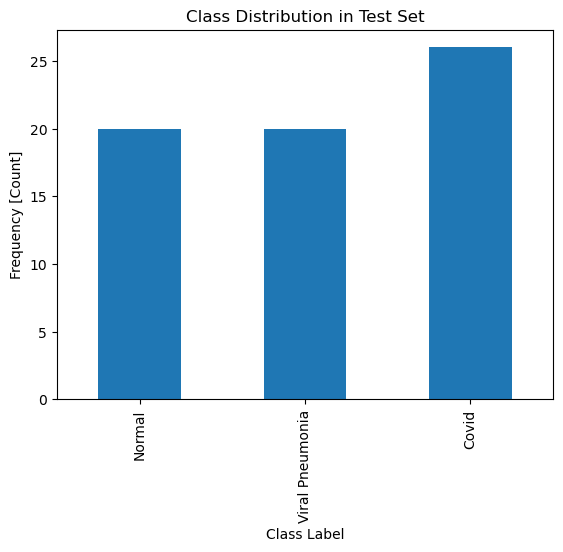

In [17]:
test_class_distributions = class_counts(test_dataset)

test_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Test Set");

In [18]:
# --- Hyperparameters ---
batch_size = 32
epochs_to_train = 23
initial_learning_rate = 1e-3
weight_decay = 1e-4
step_size = 4      # decay every 4 epochs
gamma = 0.2        # reduce LR by 0.2
loss_fn = nn.CrossEntropyLoss()
height=224
width=224

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

print(type(train_loader))  
print(type(val_loader))    
print(type(test_loader))   

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [20]:
# Load ResNet-18 with pretrained weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

in_features = model.fc.in_features

# 3. Replace the FC layer with a new one for 3 classes
model.fc = nn.Linear(in_features, 3)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
for params in model.parameters():
    params.requires_grad = False
    
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

## Checking the Size of I/O features

In [23]:
in_feat = model.fc.in_features
print(in_feat)

512


In [24]:
out_feat = model.fc.out_features
print(out_feat)

3


In [25]:
modified_last_layer = nn.Sequential(
    nn.Linear(in_feat, 253),  
    nn.ReLU(),
    nn.Linear(253, out_feat)
)

model.fc = modified_last_layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate, weight_decay=weight_decay)

print(loss_fn)
print("-------------------")
print(optimizer)

CrossEntropyLoss()
-------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [27]:
model.to(device)
print(next(model.parameters()).device)

cpu


In [28]:
# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size = step_size,
    gamma = gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [29]:
summary(model, input_size = (batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]  

In [30]:
checkpoint_dir = "C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classifier//model/"
os.makedirs(checkpoint_dir, exist_ok=True)  # creates the folder if it doesn't exist

In [31]:
from src.training import train
from src.utils import early_stopping

train_results = train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path= os.path.join(checkpoint_dir,"LR_model.pth"),
    early_stopping_fn=early_stopping
)

learning_rates, train_losses, val_losses, train_accuracies, val_accuracies, last_epoch = train_results

print(f"Training finished at epoch {last_epoch}")
print(f"Final validation accuracy: {val_accuracies[-1]*100:.2f}%")

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Initial evaluation before training:
Train loss: 1.0952, Train acc: 38.31%
Val loss: 1.0690, Val acc: 42.00%

Epoch 1/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.7079, Train acc: 72.64%
Val loss: 0.8439, Val acc: 60.00%
Learning rate: 0.001000
Checkpoint saved with validation loss 0.8439

Epoch 2/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.5685, Train acc: 82.59%
Val loss: 0.5618, Val acc: 82.00%
Learning rate: 0.001000
Checkpoint saved with validation loss 0.5618

Epoch 3/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.7167, Train acc: 60.70%
Val loss: 0.9017, Val acc: 52.00%
Learning rate: 0.001000

Epoch 4/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3170, Train acc: 93.03%
Val loss: 0.3904, Val acc: 86.00%
Learning rate: 0.001000
Checkpoint saved with validation loss 0.3904

Epoch 5/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3599, Train acc: 86.07%
Val loss: 0.4709, Val acc: 76.00%
Learning rate: 0.000200

Epoch 6/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.4075, Train acc: 81.59%
Val loss: 0.5226, Val acc: 70.00%
Learning rate: 0.000200

Epoch 7/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3579, Train acc: 85.07%
Val loss: 0.4504, Val acc: 76.00%
Learning rate: 0.000200

Epoch 8/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.3009, Train acc: 87.56%
Val loss: 0.3856, Val acc: 80.00%
Learning rate: 0.000200
Checkpoint saved with validation loss 0.3856

Epoch 9/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2087, Train acc: 92.04%
Val loss: 0.2645, Val acc: 92.00%
Learning rate: 0.000040
Checkpoint saved with validation loss 0.2645

Epoch 10/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1709, Train acc: 94.53%
Val loss: 0.2236, Val acc: 94.00%
Learning rate: 0.000040
Checkpoint saved with validation loss 0.2236

Epoch 11/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1542, Train acc: 95.52%
Val loss: 0.2165, Val acc: 92.00%
Learning rate: 0.000040
Checkpoint saved with validation loss 0.2165

Epoch 12/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1488, Train acc: 96.02%
Val loss: 0.2183, Val acc: 92.00%
Learning rate: 0.000040

Epoch 13/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1486, Train acc: 97.01%
Val loss: 0.2173, Val acc: 92.00%
Learning rate: 0.000008

Epoch 14/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1478, Train acc: 97.51%
Val loss: 0.2124, Val acc: 92.00%
Learning rate: 0.000008
Checkpoint saved with validation loss 0.2124

Epoch 15/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1475, Train acc: 97.51%
Val loss: 0.2111, Val acc: 92.00%
Learning rate: 0.000008
Checkpoint saved with validation loss 0.2111

Epoch 16/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1480, Train acc: 97.51%
Val loss: 0.2172, Val acc: 92.00%
Learning rate: 0.000008

Epoch 17/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1479, Train acc: 97.51%
Val loss: 0.2068, Val acc: 92.00%
Learning rate: 0.000002
Checkpoint saved with validation loss 0.2068

Epoch 18/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1464, Train acc: 97.51%
Val loss: 0.2114, Val acc: 92.00%
Learning rate: 0.000002

Epoch 19/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1475, Train acc: 97.51%
Val loss: 0.2150, Val acc: 92.00%
Learning rate: 0.000002

Epoch 20/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1477, Train acc: 97.51%
Val loss: 0.2088, Val acc: 92.00%
Learning rate: 0.000002

Epoch 21/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1470, Train acc: 97.51%
Val loss: 0.2107, Val acc: 92.00%
Learning rate: 0.000000

Epoch 22/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.1468, Train acc: 97.51%
Val loss: 0.2123, Val acc: 92.00%
Learning rate: 0.000000
Early stopping triggered at epoch 22


2025/08/29 15:41:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training finished at epoch 22
Final validation accuracy: 92.00%


In [32]:
torch.save(model.state_dict(), "C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classifier//model//best_model.pth")

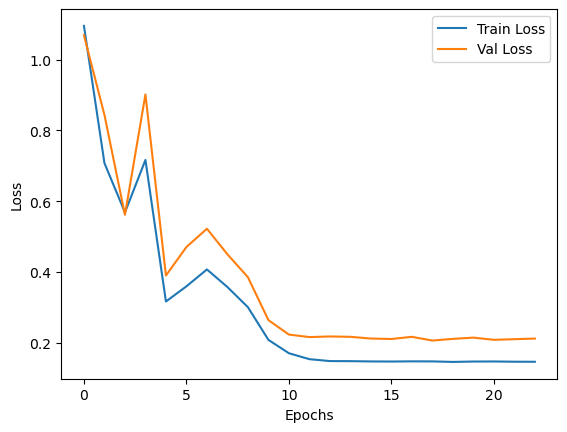

In [33]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

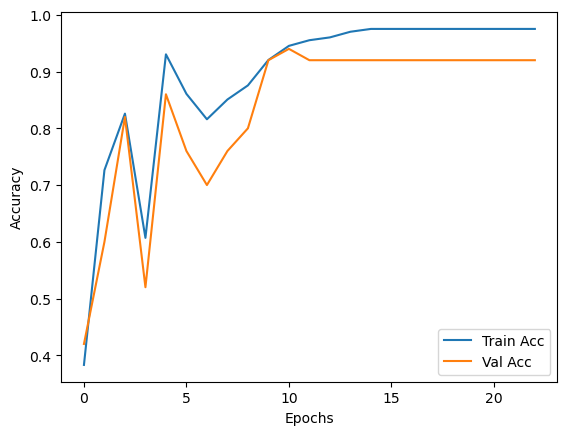

In [34]:
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [35]:
state_dict = torch.load("C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classifier//model//best_model.pth", weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))
print(confusion_matrix(all_labels, all_preds))

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.65      0.79        20
Viral Pneumonia       0.74      1.00      0.85        20

       accuracy                           0.89        66
      macro avg       0.91      0.88      0.88        66
   weighted avg       0.92      0.89      0.89        66

[[26  0  0]
 [ 0 13  7]
 [ 0  0 20]]


In [37]:
import src.grad_cam
from src.grad_cam import generate_gradcam, GradCAM
from importlib import reload

# reload 
reload(src.grad_cam)

<module 'src.grad_cam' from 'c:\\Users\\DELL\\Desktop\\endtoend-mlops\\projects\\covid_chest_classifier\\src\\grad_cam.py'>

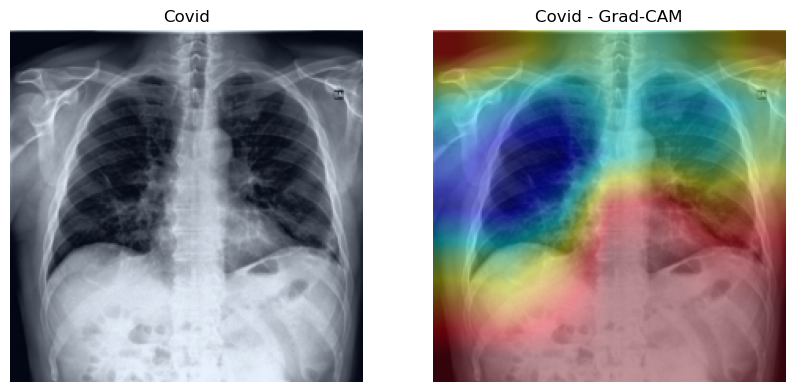

[INFO] Saved Grad-CAM comparison to gradcam_outputs\0_Covid.png


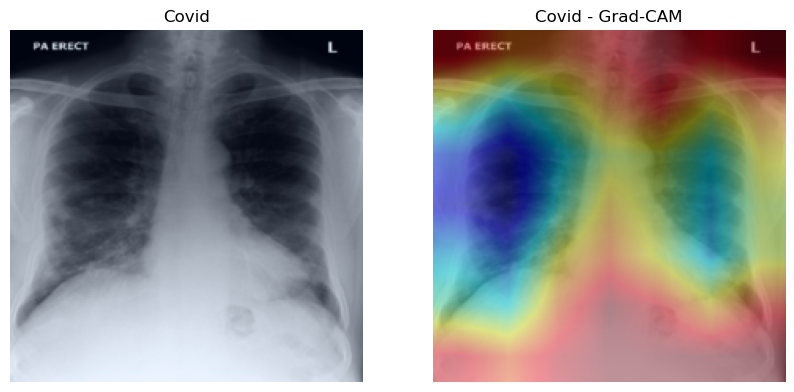

[INFO] Saved Grad-CAM comparison to gradcam_outputs\1_Covid.png


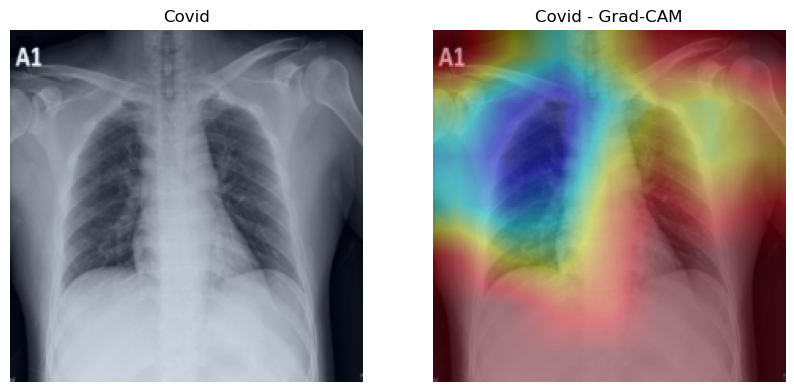

[INFO] Saved Grad-CAM comparison to gradcam_outputs\2_Covid.png


In [38]:
# Generate Grad-CAM for first 5 images
generate_gradcam(model, test_loader, classes, save_dir="gradcam_outputs", num_images=3, device=device)